# Assignment 4: Benchmarking Neural Nets with the XOR Problem

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For references, you may refer to my [lecture 10](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe) if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python/Tensorflow and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 100 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_4_ann.ipynb**.



In [ ]:
# You might want to use the following packages
import numpy as np
import os
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the train/validate/test set. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)


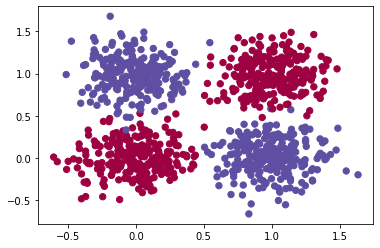

In [ ]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49) 
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK (20 pts)

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.

In [ ]:
from tensorflow import keras

my_model = keras.Sequential()
my_model.add(keras.layers.Dense(2, input_dim=2, activation='relu'))
my_model.add(keras.layers.Dense(32, activation='relu'))
my_model.add(keras.layers.Dense(1, activation='sigmoid'))
my_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

history = my_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)


Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.2548 - accuracy: 0.4750 - val_loss: 0.2563 - val_accuracy: 0.5500
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2528 - accuracy: 0.5028 - val_loss: 0.2543 - val_accuracy: 0.5875
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2516 - accuracy: 0.4958 - val_loss: 0.2527 - val_accuracy: 0.5500
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2508 - accuracy: 0.5278 - val_loss: 0.2518 - val_accuracy: 0.5250
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2501 - accuracy: 0.5514 - val_loss: 0.2508 - val_accuracy: 0.5500
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.5778 - val_loss: 0.2510 - val_accuracy: 0.5500
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2484 - accuracy: 0.5917 - val_loss: 0.2503 - val_accuracy: 0.5625
Epoch 8/100
2

In [ ]:
my_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________


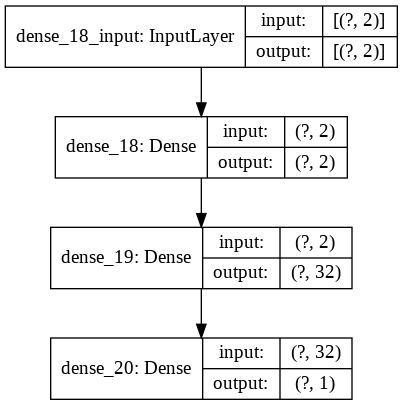

In [ ]:
keras.utils.plot_model(my_model, show_shapes=True)

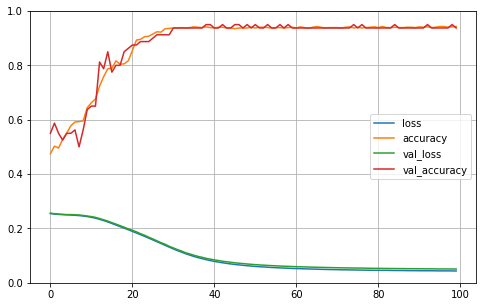

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
my_model.evaluate(x = X_test, y = y_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.0596 - accuracy: 0.9350


[0.05963188037276268, 0.9350000023841858]

- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK (60 pts)

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [ ]:
from sklearn.base import BaseEstimator
from scipy.special import softmax

class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, nn_input_dim, nn_hidden_dim, nn_output_dim, alpha):
        """
        Initialize the network with random weights

        @param: nn_input_dim: Number of nodes in the input layer
        @param: nn_hidden_dim: Number of nodes in the hidden layer
        @param: nn_output_dim: Number of nodes in the output layer
        """
        # SUBTASK 1 (10 pts): Initialize the parameters to random values.

        # MAKING CHANGES HERE BABYYY
        np.random.seed(49)
        #have to match dimensions
        #randomly choose weights, will correct themselves over time
        #set bias to zero initially, will learn over time
        self.W1 = np.random.rand(nn_input_dim, nn_hidden_dim) 
        self.b1 = np.zeros((1, nn_hidden_dim))
        self.W2 = np.random.rand(nn_hidden_dim, nn_output_dim)
        self.b2 = np.zeros((1, nn_output_dim))

        #setting alpha from passed in paramater
        self.alpha = alpha
        
    def loss(self, X, y):
        """
        Evaluate the average loss on the dataset
        """

        # Forward propagation will be needed to calculate the loss
        a1,a2 = self.forward_pass(X)
        # SUBTASK 2 (10 pts): Calculate the loss using log-loss probabilities using a2.
        # You will need to return the average loss on the data 
        data_loss = 0

        # For binary classification: -y*log(py)-(1-y)log(1-py)
        # For multi-class: -sumtoK(yk*log(pk))

        #compute sum of the logs and then divide by the length
        data_loss = -(1 / len(y)) * np.sum(np.log(a2[range(len(X)), y]))

        return data_loss


    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: a1: saved value of the output of the hidden layer
        @return: a2: activated return value of the output layer.
        """
        # SUBTASK 3 (20 pts): Implement Forward propagation.
        # Note that you must implement tanh activiation for the hidden layer, and softmax for the output layer
        
        # can use np.tanh()
        z1 = np.dot(X, self.W1) + self.b1 #vectorized computation of weights from input layer to hidden layer
        a1 = np.tanh(z1) # using tanh as activation function
        z2 = np.dot(a1, self.W2) + self.b2 #vectorized computation of weights from hidden layer to output
        # a2 = softmax(z2)  didn't have great results
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis=1, keepdims=True) #softmax activation implementation, exponentiate and normalize to get better output
        return a1, a2 

    def backward_pass(self,a1,a2,X,y):
        """
        Pass the signal back and compute the gradient

        @param: X: feature
        @param: y: label
        @param: a1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the gradient of W1
        @return: db1: the gradient of b1
        @return: dW2: the gradient of W2
        @return: db2: the gradient of b2
        """
        # You do not have to change this function, ...
        # unless you are advanced and want to use different activation function.
        m = len(y) # number of example
        delta2 = a2
        y.astype(np.int64)
        delta2[range(m), y] -= 1
        dW2 = (a1.T).dot(delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        delta1 = delta2.dot(self.W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0)
        return dW1, db1, dW2, db2

    def fit(self, X, y, epochs, X_val, y_val):
        """
        Learns parameters for the neural network and returns the model.
        
        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Gradient descent. For each batch...
        for i in range(0, epochs):

            # Forward pass
            a1,a2 = self.forward_pass(X);

            # Backpropagation
            dW1, db1, dW2, db2 = self.backward_pass(a1,a2,X,y)

            # SUBTASK 4 (10 pts): Compute the gradient descent parameter update

            #updating weights adb bias based on backward pass gradients and rate alpha
            self.W1 = self.W1 - self.alpha*dW1 
            self.b1 = self.b1 - self.alpha*db1
            self.W2 = self.W2 - self.alpha*dW2
            self.b2 = self.b2 - self.alpha*db2

            # Print the loss and validation accuracy at current epoch.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_acc: %f" 
                      %(i,epochs, self.loss(X_train, y_train), self.evaluate(X_train, y_train),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        y_pred = self.predict(X)
        return sum(y_pred == y)/len(y)

    def predict(self, X):
        """
        Predict an output

        @param: X: feature
        @return: y_pred: predicted label (0 or 1)
        """
        # SUBTASK 5 (10 pts): Implement the prediction process. 
        # Hint: It should include a forward pass, and then use the class with higher probability.
        a1,a2 = self.forward_pass(X);
        self.y_pred=[]
        #loop through all the values of the set
        for i in range(len(X)):
          #see which class haas higher probability, and set it's value in the predicitions
          if a2[i][0] > 0.5:
            self.y_pred.append(0)
          else:
            self.y_pred.append(1)

        #convert to iterable array for evaluate function
        self.y_pred = np.asarray(self.y_pred)

        return self.y_pred


    def plot_decision_boundary(self, pred_func):
        """
        Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY (20 pts)
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version. 

Epoch 0/100 - loss: 0.700874 - accuracy: 0.361111 - val_loss: 0.701689 - val_acc: 0.337500
Epoch 10/100 - loss: 0.685221 - accuracy: 0.565278 - val_loss: 0.690655 - val_acc: 0.537500
Epoch 20/100 - loss: 0.672242 - accuracy: 0.602778 - val_loss: 0.681748 - val_acc: 0.562500
Epoch 30/100 - loss: 0.649521 - accuracy: 0.675000 - val_loss: 0.658997 - val_acc: 0.712500
Epoch 40/100 - loss: 0.618015 - accuracy: 0.708333 - val_loss: 0.626339 - val_acc: 0.750000
Epoch 50/100 - loss: 0.584096 - accuracy: 0.704167 - val_loss: 0.590761 - val_acc: 0.750000
Epoch 60/100 - loss: 0.553312 - accuracy: 0.698611 - val_loss: 0.558723 - val_acc: 0.750000
Epoch 70/100 - loss: 0.526554 - accuracy: 0.700000 - val_loss: 0.531376 - val_acc: 0.750000
Epoch 80/100 - loss: 0.501178 - accuracy: 0.709722 - val_loss: 0.506312 - val_acc: 0.750000
Epoch 90/100 - loss: 0.463864 - accuracy: 0.787500 - val_loss: 0.470899 - val_acc: 0.812500

Weight vector 1: 
 [[2.08747898 0.64516274]
 [2.47189983 0.85363445]]

Bias term

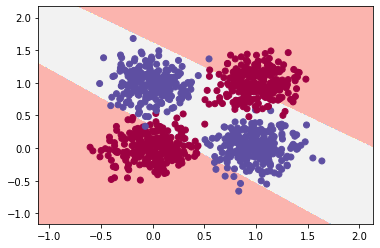

In [ ]:
# MODEL 0 here
#est hyperparameters
in_dim_0 = 2
hidden_dim_0 = 2
out_dim_0 = 2
alpha = 0.001
epochs0 = 100

#create and fit model
myModel0 = MyNeuralNet(in_dim_0, hidden_dim_0, out_dim_0, alpha)
myModel0.fit(X_train, y_train, epochs0, X_val, y_val)

#print weight and bias vectors and plot decision boundary
myModel0.plot_decision_boundary(lambda x: myModel0.predict(x))
print("\nWeight vector 1: \n", myModel0.W1)
print("\nBias term 1: \n", myModel0.b1)
print("\nWeight vector 2: \n", myModel0.W2)
print("\nBias term 2: \n", myModel0.b2)

#evaluate model on test set
eval0 = myModel0.evaluate(X_test, y_test)
print("\nEvaluation with 2 input, 2 hidden, and 2 output: ", eval0)

Epoch 0/100 - loss: 0.681120 - accuracy: 0.566667 - val_loss: 0.684490 - val_acc: 0.512500
Epoch 10/100 - loss: 0.641698 - accuracy: 0.577778 - val_loss: 0.654503 - val_acc: 0.550000
Epoch 20/100 - loss: 0.591436 - accuracy: 0.602778 - val_loss: 0.614094 - val_acc: 0.575000
Epoch 30/100 - loss: 0.526504 - accuracy: 0.787500 - val_loss: 0.554565 - val_acc: 0.800000
Epoch 40/100 - loss: 0.444944 - accuracy: 0.948611 - val_loss: 0.471952 - val_acc: 0.950000
Epoch 50/100 - loss: 0.353608 - accuracy: 0.980556 - val_loss: 0.375277 - val_acc: 0.975000
Epoch 60/100 - loss: 0.272604 - accuracy: 0.991667 - val_loss: 0.288004 - val_acc: 0.987500
Epoch 70/100 - loss: 0.212440 - accuracy: 0.991667 - val_loss: 0.222664 - val_acc: 0.987500
Epoch 80/100 - loss: 0.170963 - accuracy: 0.991667 - val_loss: 0.177544 - val_acc: 0.987500
Epoch 90/100 - loss: 0.142588 - accuracy: 0.986111 - val_loss: 0.146784 - val_acc: 0.987500

Weight vector 1: 
 [[ 0.58580228 -0.86437989  2.38435924  2.51888414]
 [ 0.76915

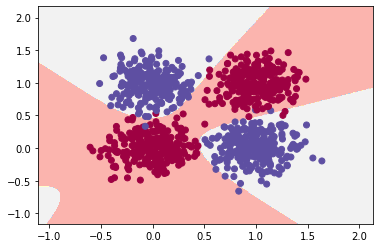

In [ ]:
# MODEL 1 here
#est hyperparameters
in_dim_1 = 2
hidden_dim_1 = 4
out_dim_1 = 2
alpha = 0.001
epochs1 = 100

#create and fit model
myModel1 = MyNeuralNet(in_dim_1, hidden_dim_1, out_dim_1, alpha)
myModel1.fit(X_train, y_train, epochs1, X_val, y_val)

#print weight and bias vectors and plot decision boundary
myModel1.plot_decision_boundary(lambda x: myModel1.predict(x))
print("\nWeight vector 1: \n", myModel1.W1)
print("\nBias term 1: \n", myModel1.b1)
print("\nWeight vector 2: \n", myModel1.W2)
print("\nBias term 2: \n", myModel1.b2)

#evaluate model on test set
eval1 = myModel1.evaluate(X_test, y_test)
print("\nEvaluation with 2 input, 4 hidden, and 2 output: ", eval1)

Epoch 0/100 - loss: 0.736989 - accuracy: 0.513889 - val_loss: 0.777483 - val_acc: 0.412500
Epoch 10/100 - loss: 0.633466 - accuracy: 0.754167 - val_loss: 0.665629 - val_acc: 0.662500
Epoch 20/100 - loss: 0.555497 - accuracy: 0.752778 - val_loss: 0.588968 - val_acc: 0.662500
Epoch 30/100 - loss: 0.475298 - accuracy: 0.851389 - val_loss: 0.521793 - val_acc: 0.812500
Epoch 40/100 - loss: 0.429973 - accuracy: 0.756944 - val_loss: 0.495696 - val_acc: 0.675000
Epoch 50/100 - loss: 0.291350 - accuracy: 0.955556 - val_loss: 0.328044 - val_acc: 0.950000
Epoch 60/100 - loss: 0.203876 - accuracy: 0.984722 - val_loss: 0.220344 - val_acc: 0.987500
Epoch 70/100 - loss: 0.159602 - accuracy: 0.987500 - val_loss: 0.171874 - val_acc: 0.987500
Epoch 80/100 - loss: 0.130276 - accuracy: 0.993056 - val_loss: 0.140624 - val_acc: 0.987500
Epoch 90/100 - loss: 0.110185 - accuracy: 0.993056 - val_loss: 0.119052 - val_acc: 0.987500

Weight vector 1: 
 [[-1.32507798  0.35344748  1.010765    1.64123658  0.40674931

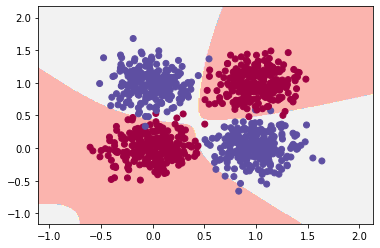

In [ ]:
# MODEL 2 here
#set hyperparamaters
in_dim_2 = 2
hidden_dim_2 = 16
out_dim_2 = 2
alpha = 0.001
epochs2 = 100

#create and fit model
myModel2 = MyNeuralNet(in_dim_2, hidden_dim_2, out_dim_2, alpha)
myModel2.fit(X_train, y_train, epochs2, X_val, y_val)

#print weight and bias vectors and plot decision boundary
myModel2.plot_decision_boundary(lambda x: myModel2.predict(x))
print("\nWeight vector 1: \n", myModel2.W1)
print("\nBias term 1: \n", myModel2.b1)
print("\nWeight vector 2: \n", myModel2.W2)
print("\nBias term 2: \n", myModel2.b2)

#evaluate model on test set
eval2 = myModel2.evaluate(X_test, y_test)
print("\nEvaluation with 2 input, 16 hidden, and 2 output: ", eval2)

Epoch 0/100 - loss: 0.761636 - accuracy: 0.587500 - val_loss: 0.715241 - val_acc: 0.600000
Epoch 10/100 - loss: 0.949481 - accuracy: 0.668056 - val_loss: 0.830828 - val_acc: 0.700000
Epoch 20/100 - loss: 0.674428 - accuracy: 0.688889 - val_loss: 0.608039 - val_acc: 0.712500
Epoch 30/100 - loss: 0.532453 - accuracy: 0.693056 - val_loss: 0.488908 - val_acc: 0.712500
Epoch 40/100 - loss: 0.378096 - accuracy: 0.787500 - val_loss: 0.359183 - val_acc: 0.800000
Epoch 50/100 - loss: 0.219088 - accuracy: 0.943056 - val_loss: 0.226691 - val_acc: 0.912500
Epoch 60/100 - loss: 0.161222 - accuracy: 0.972222 - val_loss: 0.177165 - val_acc: 0.975000
Epoch 70/100 - loss: 0.132573 - accuracy: 0.979167 - val_loss: 0.147692 - val_acc: 0.975000
Epoch 80/100 - loss: 0.112683 - accuracy: 0.983333 - val_loss: 0.126512 - val_acc: 0.975000
Epoch 90/100 - loss: 0.098281 - accuracy: 0.983333 - val_loss: 0.110897 - val_acc: 0.975000

Weight vector 1: 
 [[ 0.17487128  0.13732272  1.49409821  0.53850725  0.68716474

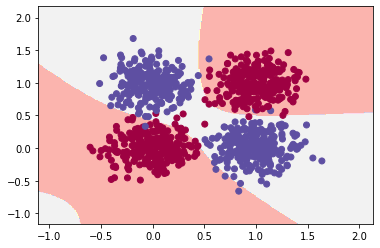

In [ ]:
# MODEL 3 here
#set hyperparamaters
in_dim_3 = 2
hidden_dim_3 = 32
out_dim_3 = 2
alpha = 0.001
epochs3 = 100

#Create and fit model
myModel3 = MyNeuralNet(in_dim_3, hidden_dim_3, out_dim_3, alpha)
myModel3.fit(X_train, y_train, epochs3, X_val, y_val)

#print weight and bias vectors and plot decision boundary
myModel3.plot_decision_boundary(lambda x: myModel3.predict(x))
print("\nWeight vector 1: \n", myModel3.W1)
print("\nBias term 1: \n", myModel3.b1)
print("\nWeight vector 2: \n", myModel3.W2)
print("\nBias term 2: \n", myModel3.b2)

#evaluate model on test set
eval3 = myModel3.evaluate(X_test, y_test)
print("\nEvaluation with 2 input, 32 hidden, and 2 output: ", eval3)

Epoch 1/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2483 - accuracy: 0.5125 - val_loss: 0.2487 - val_accuracy: 0.4125
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2442 - accuracy: 0.5139 - val_loss: 0.2458 - val_accuracy: 0.4125
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2391 - accuracy: 0.5139 - val_loss: 0.2423 - val_accuracy: 0.4125
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2332 - accuracy: 0.5347 - val_loss: 0.2367 - val_accuracy: 0.6500
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2267 - accuracy: 0.7431 - val_loss: 0.2308 - val_accuracy: 0.8375
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2197 - accuracy: 0.8694 - val_loss: 0.2246 - val_accuracy: 0.8750
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.8417 - val_loss: 0.2186 - val_accuracy: 0.8750
Epoch 8/100
2

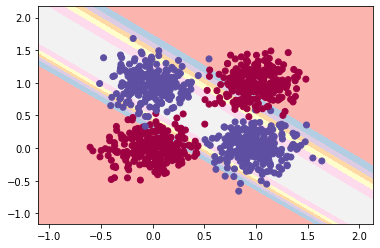

In [ ]:
# COMPARISONS WITH THE STANDARD LIBRARY 
lib_net = keras.Sequential()
lib_net.add(keras.layers.Dense(2, input_dim=2, activation='relu'))
lib_net.add(keras.layers.Dense(32, activation='relu'))
lib_net.add(keras.layers.Dense(1, activation='sigmoid'))
lib_net.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
#train the model
history = lib_net.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

#plot decision boundary
myModel3.plot_decision_boundary(lambda x: lib_net.predict(x))

#evaluate performance
score = lib_net.evaluate(x = X_test, y = y_test)
print("\nEvaluation performance: \n", score)

## Reflection
Write at least a paragraph answering these prompts: How did your own network perform? Is there any major differences between the implementations? Finally, reflecting on your experience implementing a learning algorithm for this assignment (Was it hard/easy/fun?, From which part did you learn the most?)!

Implementing my own ANN was really cool. I think this assignment is one of the better ones because it's more modernly useful, that's not to say that the other assignments weren't foundational. That being said, this was definetly one of the harder ones, concepts as well as the code were diffcult to wrap my head around. There's a lot of weird dimensionality, which is why I'm glad I took linear algebra. I think I learned the most from implementing the forward pass, the update and initialization are somewhat intuitive, but the forward pass and the number of different things you can do in it make it the hardest and most important. As for the performance of my implementation it performed extremely well. It performed better than the library implementation in all but one test case I ran, which had all the dimensions equal to 2. I kept the input and output dimensions equal to 2 and changes the amount of hidden layers in the other tests. The results are below:

hidden layers | performance
--- | ---
4 | .99
16 | .97
32 | .975

The library implementation only performed at .925. The decision boundaries became increasingly hyperbolic as I increased the number of hidden layers, meaning it had 2 distinct bubbles for each group. The library's decision boundary and my first test look similar, they look just like support vector machine decision boundaries. My other three tests that performed very well had a more hyperbolic pattern to their decision boundaries.

---
# Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [lecture 10](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe)
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 4:...".

Part of the codes used in this assignment is modified from Konstantinos Kitsios under the 3-Clause BSD License. Best of luck and have fun!